In [1]:
import numpy as np
from plind.plmodel import plmodel
from plind.contour_dict import realcontour_1D
from plind.contour_dict import realcontour_nd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1D Rational Lens

This example shows the evaluation of the diffraction integral for a lens with potential $S(x; y, \nu, \alpha) =\nu [ (x-y)^2 + \frac{\alpha}{1+x^2} ]$. The Morse function is $h(z) = \mathrm{Re} iS(z)$ and the gradient of the Morse function is given by $\frac{dh}{dz} = 2 i [ z - y  - \frac{z \alpha}{(1+z^2)^2}]^*$ where $*$ indicated the complex conjugate.

In [38]:
# Define the integrand and the Morse gradient
def rat_expfun(x, y, alpha, nu):
    return 1j*nu*((x-y)**2 + (alpha/(1+x*x)) )

def rat_grad(x, y, alpha, nu):
    return 1j*np.conj(2*((x-y) - (x*alpha/(1+x*x)**2)))

In [39]:
# Set Lens Parameters
alpha = 2
nu = 10
y = 0

# Set plind parameters
delta = 0.1  # minimum grid spacing
thresh = -100  # minimum value of the Morse function points can attain before being discarded
domain = [-2, 2]  # bounds of the initial integration domain on the real line
Ninit = 100  # number of points for grid on the initial domain
dt_init = 8e-3  # initial timestep for the ODE solver
tmax = 8e-1  # maximum integration time for ODE solver

In [40]:
# Initialize initial intergation contour on the real axis
init_contour = realcontour_1D(Ninit, domain)

# Initialize plmodel object
pmod = plmodel(init_contour, rat_expfun, grad=rat_grad, expargs=[y, alpha, nu])

# Flow contour to Lefschetz thimbles
pmod.descend(delta, thresh, tmax, dt_init, verbose=True)

# Integrate
pmod.integrate()
print("Integral = ", pmod.integral[0], "\n",
      "Estimate of error magnitude =", pmod.integral[1])

total steps: 136 current time: 0.8000370460427776
Integral =  (1.492282758214998+0.40917539478393694j) 
 Estimate of error magnitude = 1.355508365499634e-10


/Users/DylanJow/plind/plind/descend/core.py:34: RuntimeWarning: divide by zero encountered in true_divide
  delta = np.min((np.divide(tol, 2*R))**(1/4))


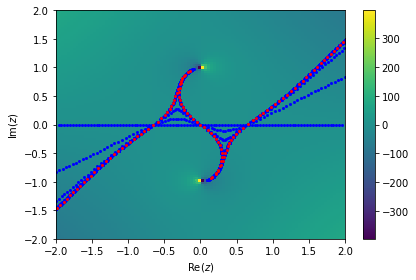

In [41]:
# Plot the Lefschetz thimbles
u, v = np.meshgrid(np.linspace(domain[0], domain[1], 100), np.linspace(domain[0], domain[1], 100), indexing='ij')
z = u + 1j*v

fig, ax = plt.subplots()
ax.set_xlabel("Re($z$)")
ax.set_ylabel("Im($z$)")
ax.set_ylim(domain[0], domain[1])
ax.set_xlim(domain[0], domain[1])
# Plot h
im = ax.pcolormesh(u, v, np.real(rat_expfun(z, y, alpha, nu)))
fig.colorbar(im, ax=ax)

# Plot progress towards Lefschetz thimble in blue
for k in np.linspace(0, pmod.trajectory.shape[0], pmod.trajectory.shape[0]//4, endpoint=False):
    k = int(k)
    ax.scatter(pmod.trajectory[k].points.real[1:-1].flatten(), pmod.trajectory[k].points.imag[1:-1].flatten(), s=4, c='b')
    
#Plot final contour in red
ax.scatter(pmod.contour.points.real[1:-1].flatten(), pmod.contour.points.imag[1:-1].flatten(), s=4, c='r')
ax.set_rasterization_zorder(-10)
plt.tight_layout()
plt.show()

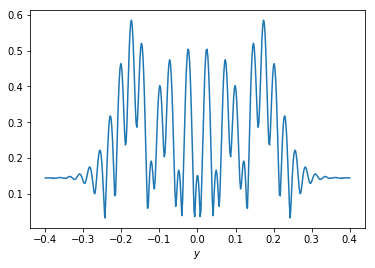

In [30]:
# Compute integral for multiple values of y
alpha = 2
nu = 100

Ys = np.linspace(-0.4, 0.4, 400)

INTVALS = []
for y in Ys:
    init_contour = realcontour_1D(100, [-1,1])
    pmod = plmodel(init_contour, rat_expfun, grad=rat_grad, expargs=[y, alpha, nu])
    pmod.descend(0.1, -10, 8e-1, 8e-3, verbose=False)
    pmod.integrate()
    INTVALS.append(np.abs(pmod.integral[0]))
    
fig, ax = plt.subplots()
ax.set_xlabel('$y$')
ax.plot(Ys, INTVALS)
plt.show()


# 2D and 3D Gaussian

Here we compute the nD Gaussian integral, $S(\vec{x}) = \vec{x}^2$. This has a known value of $(i \pi)^{n/2}$.

In [64]:
# define integral and gradient
def Gauss_exp(z, ndim):
    gauss_sum=0
    if (ndim ==1):
        gauss_sum=z**2
    else: 
        for i in range(ndim):
            gauss_sum= gauss_sum + z[i]**2
    return 1j*(gauss_sum)

def Gauss_grad(z, ndim):
    return 2*1j*np.conj(z)

def Gauss_answer(ndim):
    return (np.pi*1j)**(ndim/2)

In [65]:
# 2D Gaussian
ndim = 2

# pmod parameters
delta = 0.4
thresh = -50
domain = [-0.5, 0.5, -0.5, 0.5]
Ninit = 10  # for 2D this creates a Ninit x Ninit grid over the domain
dt_init = 8e-3  
tmax = 2

# Initialize
init_contour = realcontour_nd(Ninit, domain)
pmod = plmodel(init_contour, Gauss_exp, grad=Gauss_grad, expargs=[ndim])

# Flow and integrate
pmod.descend(delta, thresh, tmax, dt_init)
pmod.integrate()
print("Result:", pmod.integral[0], "\n" 
      "Answer:", Gauss_answer(ndim), "\n" 
      "Difference:", np.abs(pmod.integral[0]-Gauss_answer(ndim)))
      
      

/Users/DylanJow/plind/plind/descend/core.py:34: RuntimeWarning: divide by zero encountered in true_divide
  delta = np.min((np.divide(tol, 2*R))**(1/4))


total steps: 23 current time: 2.0046569475091065
Result: (-3.2617544732868597e-16+3.1415926535897913j) 
Answer: 3.141592653589793j 
Difference: 1.8060548284379727e-15


We can check that the contour has converged to the thimble by plotting the integrand along the final contour. If the imaginary part is roughly constant, we know we have converged.

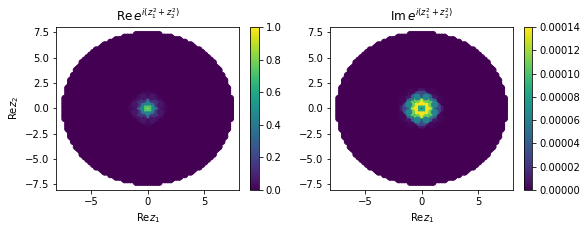

In [79]:
intfun = plind.get_intfun()
xs = np.real(pmod.contour.points[:,0])
ys = np.real(pmod.contour.points[:,1])


intvals = np.array([intfun(p, *pmod.expargs) for p in pmod.contour.points])

fig, ax = plt.subplots(1,2, figsize=(9,3))
im0 = ax[0].scatter(xs, ys, c=intvals.real)
im1 = ax[1].scatter(xs, ys, c=intvals.imag)
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])

ax[0].set_xlabel('$\mathrm{Re}z_1$')
ax[0].set_ylabel('$\mathrm{Re}z_2$')
ax[1].set_xlabel('$\mathrm{Re}z_1$')
ax[0].set_title('$\mathrm{Re}\,e^{i(z_1^2 + z_2^2)}$')
ax[1].set_title('$\mathrm{Im}\,e^{i(z_1^2 + z_2^2)}$')
plt.show()



We can also compute the 3D Gaussian case, $S(z) = z_1^2 + z_2^2 + z_3^2$.

In [84]:
ndim = 3

# pmodel params
delta = 1
thresh = -30
domain = [-0.5, 0.5, -0.5, 0.5, -0.5, 0.5]
Ninit = 20
dt_init = 0.1
tmax = 2.0

# initialize
init_contour = realcontour_nd(Ninit, domain)
pmod = plmodel(init_contour, Gauss_exp, grad=Gauss_grad, expargs=[ndim])

# descend
pmod.descend(delta, thresh, tmax, dt_init)

# refine grid
pmod.contour.refine_edges(delta/10)   # you can initialize with a sparse grid, flow,
                                        # and then refine once the thimbles are reached

# Integrate
pmod.integrate()
print("Result:", -pmod.integral[0], "\n" 
      "Answer:", Gauss_answer(ndim), "\n" 
      "Difference:", np.abs(pmod.integral[0] + Gauss_answer(ndim)))

total steps: 23 current time: 2.0000341200812666
Result: (-3.9362003598977893+3.93619667872319j) 
Answer: (-3.9374024864306048+3.937402486430605j) 
Difference: 0.0017026686195972221


Note this example shows a problem in the code which occurs for dimensions higher than 2D. The simplices that form the integration contour do not have an orientation specified, and in the course of flowing, the orientation can flip causing an overall sign error. We intend to resolve this issue in future

# 2D Rational Lens

This example shows the evaluation of the diffraction integral for a 2D lens with potential $S(\vec{z}; \vec{y}, \nu, \alpha) =\nu [ (\vec{z}-\vec{y})^2 + \frac{\alpha}{1+z_1^2+2 z_2^2} ]$. 

In [20]:
def rat2d_expfun(x, y, alpha, nu):
    return 1j*nu*((x[0]-y[0])**2 + (x[1]-y[1])**2 + (alpha/(1+x[0]*x[0]+2*x[1]*x[1])) )

def rat2d_grad(x, y, alpha, nu):
    x = x.T
    return np.array([1j*np.conj(2*((x[0]-y[0]) - (x[0]*alpha/(1+x[0]*x[0]+2*x[1]*x[1]))**2)),
                     1j*np.conj(2*((x[1]-y[1]) - (2*x[1]*alpha/(1+x[0]*x[0]+2*x[1]*x[1]))**2))]).T

In [39]:
# lens paramaters
alpha = 1.3
nu = 100
y = [0., 0.]

# pmod parameters
delta = 0.05
thresh = -10
domain = [-2., 2., -2., 2.]
Ninit = 10
dt_init = 8e-3
tmax = 0.3

# initialize
init_contour = realcontour_nd(Ninit, domain)
pmod = plmodel(init_contour, rat2d_expfun, grad=rat2d_grad, expargs=[y, alpha, nu])

# descend
pmod.descend(delta, thresh, tmax, dt_init)
pmod.integrate()
print("Integral = ", pmod.integral[0], "\n",
     "Estimate of error magnitude =", pmod.integral[1])

total steps: 18 current time: 0.30533543781683725


/Users/DylanJow/plind/plind/descend/core.py:34: RuntimeWarning: divide by zero encountered in true_divide
  delta = np.min((np.divide(tol, 2*R))**(1/4))


Integral =  (9186977463952.137+39974347609902.914j) 
 Estimate of error magnitude = 1.5573617778790192e+17


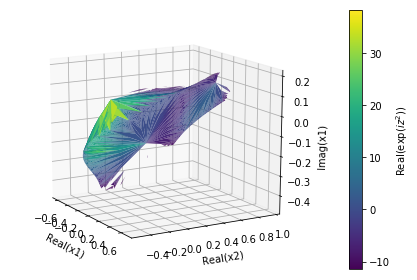

In [40]:
x1 = pmod.contour.points[:,0].real
x2 = pmod.contour.points[:,1].real
intvals = np.array([pmod.intfun(p, *pmod.expargs) for p in pmod.contour.points])
simpvals = np.zeros(pmod.contour.simplices.shape[0], dtype=np.complex)
for j, simp in enumerate(pmod.contour.simplices):
    mid = np.sum(pmod.contour.points[simp], 0)/len(simp)
    simpvals[j] = pmod.expfun(mid, *pmod.expargs)
    
fig = plt.figure(figsize=(6,4))
ax0 = fig.add_subplot(1, 1, 1, projection='3d')
ax0.set_xlabel('Real(x1)')
ax0.set_ylabel('Real(x2)')
ax0.set_zlabel('Imag(x1)')
ax0.view_init(elev=15,azim=-30)
col0 = ax0.plot_trisurf(x1, x2, pmod.contour.points[:,0].imag, triangles=pmod.contour.simplices, cmap=plt.cm.viridis,edgecolors='k',linewidths=0.)
col0.set_array(simpvals.real)
cbar0 = fig.colorbar(col0,pad=0.1,label=r'Real($\exp(iz^2)$)')
plt.tight_layout()
plt.show()


In [ ]:
# Compute integral for different values of y
Y1, Y2 = np.meshgrid(np.linspace(-0.5, 0.5, 20), np.linspace(-0.5, 0,5, 20))

INTVALS = []
for y1,y2 in zip(Y1.flatten(), Y2.flatten()):
    y = [y1,y2]
    init_contour = realcontour_nd(Ninit, domain)
    plind = plmodel(init_contour, rat2d_expfun, grad=rat2d_grad, expargs=[y, alpha, nu])
    plind.descend(delta, thresh, tmax, dt_init, verbose=False)
    pmod.integrate()
    INTVALS.append(pmod.integral[0])
INTVALS = np.array(INTVALS).reshape(Y1.shape)

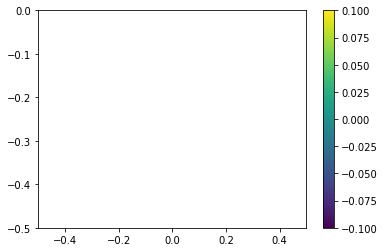

In [157]:
fig, ax = plt.subplots()
im = ax.pcolormesh(Y1, Y2, np.abs(INTVALS)**2)
fig.colorbar(im, ax=ax)
plt.show()

In [158]:
INTVALS

array([[nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj, nan+nanj]])